In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from tqdm import tqdm




In [8]:
from scipy.optimize import minimize, Bounds

def estimated_latency_n_1(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2.0,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    # L = np.prod([h_1,k,n])+np.prod([h_2,n]+np.prod([h_3,k]))+np.prod([h_4,n/k])+np.prod([h_5,1/])
    Lnk = h_1*k*n + h_2*n + h_3*k + h_4*n/k + h_5/k + h_6*n*np.log(n/(n-k)) + h_7*n/k*np.log(n/(n-k)) + h_8/k*np.log(n/(n-k))
    return Lnk

def estimated_derivative_k(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])
    # print(h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8)

    dk = n*h_1 + h_3 - (n*h_4 + h_5)/k**2 + n*h_6/(n-k) + (n*h_7 + h_8)*(-1/k**2 * np.log(n/(n-k)) + 1/k*(n-k))
    return dk

def estimated_derivative_n(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    dn = h_1*k + h_2 + h_4/k + (h_6 + h_7/k)*(np.log(n/(n-k)) - k/(n-k)) - h_8/(n*(n-k))
    return dn

def get_latency_composition(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h2 = np.prod([2.0,IW,1/mu_m+theta_m])
    h3 = np.prod([2,O,1/mu_m+theta_m])
    h4_theta_rec = np.prod([4,IW,theta0_rec])
    h4_theta_sen = np.prod([4,O,theta0_sen])
    h5 = np.prod([Nc,theta_cmp])
    h6_theta_rec = np.prod([4,Iov,theta0_rec])
    h6_mu_rec = np.prod([4,Iov,1/mu0_rec])
    h7_mu_rec = np.prod([4,IW,1/mu0_rec])
    h7_mu_sen = np.prod([4,O,1/mu0_sen])
    h8 = np.prod([Nc,1/mu_cmp])

    master_enc = h1*k*n + h2*n
    master_dec = h3*k
    master_latency = master_enc + master_dec

    worker_tr_mu = h6_mu_rec*n*np.log(n/(n-k)) + (h7_mu_rec + h7_mu_sen)*n/k*np.log(n/(n-k))
    worker_tr_theta = (h4_theta_rec + h4_theta_sen)*n/k + h6_theta_rec*n

    worker_cmp_mu = h8/k*np.log(n/(n-k))
    worker_cmp_theta = h5/k

    worker_latency = worker_tr_mu + worker_tr_theta + worker_cmp_mu + worker_cmp_theta
    overall_latency = master_latency + worker_latency
    return (overall_latency, master_enc, master_dec, worker_tr_mu, worker_tr_theta, worker_cmp_mu, worker_cmp_theta)

def get_latency_composition_2(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])
    Lnk = h_1*k*n + h_2*n + h_3*k + h_4*n/k + h_5/k + h_6*n*np.log(n/(n-k)) + h_7*n/k*np.log(n/(n-k)) + h_8/k*np.log(n/(n-k))
    return Lnk, h_1*k*n, h_2*n, h_3*k, h_4*n/k, h_5/k, h_6*n*np.log(n/(n-k)), h_7*n/k*np.log(n/(n-k)), h_8/k*np.log(n/(n-k))

def objective_function(x, *args):
    n, k = x
    h1, h2, h3, h4, h5, h6, h7, h8 = args
    return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n * np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))

def solve_nk_scipy(system_params, conv_params):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2.0,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    constraints = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]}) # n >= k
    bounds = Bounds([3, 2], [np.inf, np.inf])

    initial_guess = [3, 2]
    result = minimize(objective_function, initial_guess, args=(h_1, h_2, h_3, h_4, h_5, h_6, h_7, h_8), constraints=constraints, bounds=bounds)
    print(f'n*,k*={result.x}   T*={result.fun}')

    if not result.success:
        print(result.message)
    return (result.fun, *result.x)

    # n, k = cp.Variable(), cp.Variable()

    # objective = cp.Minimize(h_1*k*n + h_2*n + h_3*k + h_4*n/k + h_5/k + h_6*n/cp.log(n/(n-k)) + h_7*n/k*cp.log(n/(n-k)) + h_8/k*cp.log(n/(n-k)))
    # constraint = [n - k > 0, k - 2 >= 0]
    # problem = cp.Problem(objective, constraint)
    # problem.solve()

    # print(f'n*={n.value}, k*={k.value}, T*={problem.value}')


In [9]:
# computation scenario
B = 1
# input shape
C_i, H_i, W_i = 64, 224, 224
# output shape
C_o, H_o, W_o = 64, 224, 224

kernel_size, stride, padding = 3, 1, 1

conv_params = (B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding)

scale = 100000  # shape (scale, n) for generating random variables, n values per group

mu_m, theta_m = 5e8, 2e-9


mus_tr = [1e6, 1e7, 1e8]  # 传输参数的初始值
thetas_tr = [1e-7, 1e-8, 1e-9]
mus_cmp = [1e7, 1e8, 1e9]
thetas_cmp = [1e-7, 1e-8, 1e-9]

mu_tr = mus_tr[2]
theta_tr = thetas_tr[1]
mu_cmp = mus_cmp[-1]
theta_cmp = thetas_cmp[-1]

generate_data = True
actual = True

def search_optimal_nk(system_params, conv_params):
    '''
    对于给定的系统参数以及卷积参数（计算场景参数），返回实际以及估计的最优的(n,k) pair以及对应的时延
    '''
    assert len(system_params) == 6
    assert len(conv_params) == 10
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    n_range = range(3, 100)
    ETc_n_k_actual = []  # list to store tuple (E_Tc_actual, n, k*)
    ETc_n_k_estimated = []  # list to store tuple (E_Tc_estimated, n, k*)
    for n in tqdm(n_range):
        mu_rec_n = mu0_rec / n
        mu_sen_n = mu0_sen / n
        theta_rec_n = theta0_rec * n
        theta_sen_n = theta0_sen * n
        if generate_data:
            Es_kth_Ts_w = []
            Es_sum_kth= []
            # compositions = []
            k0 = 2
            for k in range(k0, n):
                Wpo = W_o / k
                Wpi = kernel_size + (Wpo - 1) * stride

                Nenc = np.prod([(2 * k - 1), n, B, C_i, H_i, Wpi])  # in FLOPs (floating point operations)
                Ndec = np.prod([(2 * k - 1), k, B, C_o, H_o, Wpo])  # in FLOPs
                Nconv = np.prod([B, C_o, H_o, Wpo, C_i, kernel_size ** 2]) \
                         + np.prod([B, C_o, H_o, Wpo, C_i * (kernel_size ** 2)])  # in FLOPs
                Nin = np.prod([B, C_i, H_i, Wpi, 4])  # in bytes
                Nout = np.prod([B, C_o, H_o, Wpo, 4])  # in bytes

                # Tenc = 2 / mu_m + Nenc * theta_m  # ???
                # Tdec = 2 / mu_m + Ndec * theta_m
                Tenc = (1 / mu_m + theta_m) * Nenc
                Tdec = (1 / mu_m + theta_m) * Ndec
                Tm = Tenc + Tdec

                _murec = Nin / mu_rec_n
                _mucmp = Nconv / mu_cmp
                _musen = Nout / mu_sen_n

                Ts_rec = random.exponential(_murec, (scale, n))
                Ts_cmp = random.exponential(_mucmp, (scale, n))
                Ts_sen = random.exponential(_musen, (scale, n))

                Ts_w = Ts_rec + Ts_cmp + Ts_sen
                # cmp_theta_sum = Nconv * theta_cmp
                # tr_theta_sum = Nin * theta_rec_n + Nout * theta_sen_n
                sum_offset = Nin * theta_rec_n + Nconv * theta_cmp + Nout * theta_sen_n
                
                # kth order statistic of Ts_w, Ts_rec, Ts_cmp, Ts_sen (合起来求o.s.)
                kth_Ts_w = np.partition(Ts_w, k - 1, axis=1)[:, k - 1]
                E_kth_Ts_w = np.mean(kth_Ts_w) + sum_offset + Tm
                Es_kth_Ts_w.append(E_kth_Ts_w)

                # 分开求order statistic
                kth_Ts_rec = np.partition(Ts_rec, k - 1, axis=1)[:, k - 1]
                kth_Ts_cmp = np.partition(Ts_cmp, k - 1, axis=1)[:, k - 1]
                kth_Ts_sen = np.partition(Ts_sen, k - 1, axis=1)[:, k - 1]

                # estimation
                sum_kth_Ttr = kth_Ts_rec + kth_Ts_sen
                # tr_mu_sum = np.mean(sum_kth_Ttr)
                # cmp_mu_sum = np.mean(kth_Ts_cmp)

                sum_kth_Ts = sum_kth_Ttr + kth_Ts_cmp
                E_sum_kth = np.mean(sum_kth_Ts) + sum_offset + Tm
                Es_sum_kth.append(E_sum_kth)

                # compositions.append((np.sum([Tm, tr_mu_sum, tr_theta_sum, cmp_mu_sum, cmp_theta_sum]), Tm, tr_mu_sum, tr_theta_sum, cmp_mu_sum, cmp_theta_sum))

            optimal_k_actual = k0 + np.argmin(Es_kth_Ts_w)
            ETc_actual = np.min(Es_kth_Ts_w)
            ETc_n_k_actual.append((ETc_actual, n, optimal_k_actual))

            optimal_k_estimated = k0 + np.argmin(Es_sum_kth)
            ETc_estimated = np.min(Es_sum_kth)
            ETc_n_k_estimated.append((ETc_estimated, n, optimal_k_estimated))#, compositions[np.argmin(Es_sum_kth)]))
            # print(f'    n={n}, ETc_actual={ETc_actual}, ETc_estimated={ETc_estimated}')

            k0 = min(optimal_k_actual, optimal_k_estimated)
            if n>3:
                actual_larger = ETc_n_k_actual[-1][0] > ETc_n_k_actual[-2][0]
                estimated_larger = ETc_n_k_estimated[-1][0] > ETc_n_k_estimated[-2][0]
                if actual_larger and estimated_larger:
                    break
            
    ETc_n_k_actual.sort(key=lambda x: x[0])
    ETc_n_k_estimated.sort(key=lambda x: x[0])
    return ETc_n_k_actual[0], ETc_n_k_estimated[0]
    # return (n_optimal_actual, k_optimal_actual), (n_optimal_estimated, k_optimal_estimated)


# $\mu^{tr}_0$

In [10]:
# test impact of mu0_tr

mus_tr = [1e7,1e8,1e9]  # 传输参数的初始值
# mus_tr = [1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9]
# mus_tr = [1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8]
xticks = '1e6,1e7,1e8'.split(',')
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [5e7,1e8,2e8]
thetas_cmp = [1e-9,1e-8,1e-7]

# theta0_tr = theta_tr
theta0_tr = 1e-9


In [11]:

mus_tr_results = []

for mu0_tr in mus_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_nk(system_params, conv_params)
    T_approx, n_approx, k_approx = results[-1]
    print(f'partial n:{estimated_derivative_n(system_params, conv_params, n_approx, k_approx)}, partial k:{estimated_derivative_k(system_params, conv_params, n_approx, k_approx)}')
    print(estimated_derivative_k(system_params, conv_params, n_approx, k_approx-1), estimated_derivative_k(system_params, conv_params, n_approx, k_approx+1))
    Lnk, h1,h2,h3,h4,h5,h6,h7,h8 = get_latency_composition_2(system_params, conv_params, n_approx, k_approx)
    # master_latency = master_enc + master_dec
    
    print(f'Approx: Lnk={Lnk}, h1={h1}, h2={h2}, h3={h3}, h4={h4}, h5={h5}, h6={h6}, h7={h7}, h8={h8}')
    print(results)
    print(estimated_latency_n_1(system_params, conv_params, n_approx, k_approx))
    mus_tr_results.append(results)

(10000000.0, 1e-09, 1000000000.0, 1e-09, 10000000.0, 1e-09)


 19%|█▊        | 18/97 [00:19<01:24,  1.07s/it]


partial n:-0.0042208366405643745, partial k:164.4820260740278
219.33152439740445 127.90298716244935
Approx: Lnk=4.745189899578382, h1=0.022937600000000002, h2=0.5160960000000001, h3=0.12845056, h4=0.10276044799999999, h5=0.7398752256000001, h6=0.06598736305069969, h7=2.9562338646713457, h8=0.2128488382563369
((5.782641425591578, 12, 8), (4.581815876137565, 20, 5))
4.745189899578382
(100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)


 15%|█▌        | 15/97 [00:11<01:05,  1.26it/s]


partial n:-0.0017391936124551838, partial k:8.961999841523227
11.383623636309235 7.076292015456739
Approx: Lnk=1.846101922470499, h1=0.031195136000000002, h2=0.43868160000000006, h3=0.205520896, h4=0.054591488, h5=0.46242201600000005, h6=0.012399847545189108, h7=0.347195731265295, h8=0.2940952076600146
((1.8942944813760316, 15, 10), (1.7779624306406814, 17, 8))
1.846101922470499
(1000000000.0, 1e-09, 1000000000.0, 1e-09, 1000000000.0, 1e-09)


 14%|█▍        | 14/97 [00:09<00:58,  1.42it/s]

partial n:-0.003669446650786494, partial k:3.1339175388975624
4.031264572247327 2.414496354086271
Approx: Lnk=1.5129029517171628, h1=0.033030144000000004, h2=0.41287680000000004, h3=0.231211008, h4=0.045671310222222226, h5=0.411041792, h6=0.0015169617952220842, h7=0.037755493569971876, h8=0.33979944212974683
((1.46840310592491, 16, 9), (1.4569278654242122, 16, 9))
1.5129029517171628


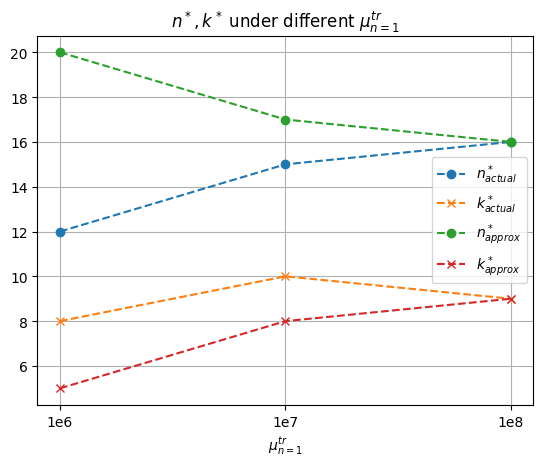

In [12]:
# draw impact of mu0_tr
optimal_ns_actual = [actual[1] for actual, _ in mus_tr_results]
optimal_ks_actual = [actual[2] for actual, _ in mus_tr_results]
optimal_ns_estimated = [estimated[1] for _, estimated in mus_tr_results]
optimal_ks_estimated = [estimated[2] for _, estimated in mus_tr_results]

plt.figure()
plt.grid()
plt.title(r'$n^*,k^*$ under different $\mu^{tr}_{n=1}$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.xticks(np.arange(len(mus_tr)), labels=xticks)
plt.xlabel('$\mu^{tr}_{n=1}$')
plt.legend()
plt.show()


(1000000.0, 1e-08, 100000000.0, 1e-08, 1000000.0, 1e-08)
n*,k*=[32.05492451  7.10804581]   T*=42.962858646936816
(10000000.0, 1e-08, 100000000.0, 1e-08, 10000000.0, 1e-08)
n*,k*=[24.49214162 10.9962855 ]   T*=14.41438127138191
(100000000.0, 1e-08, 100000000.0, 1e-08, 100000000.0, 1e-08)
n*,k*=[22.95743844 12.5844928 ]   T*=11.059938398498232


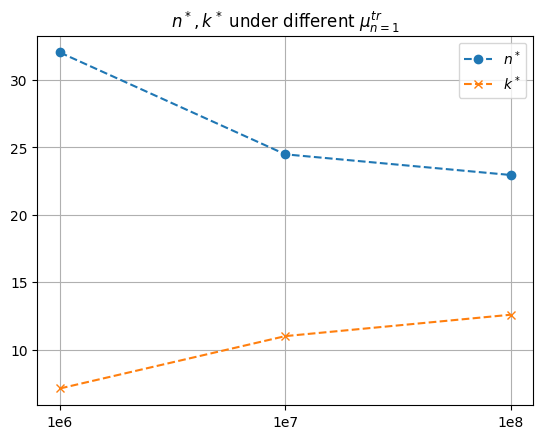

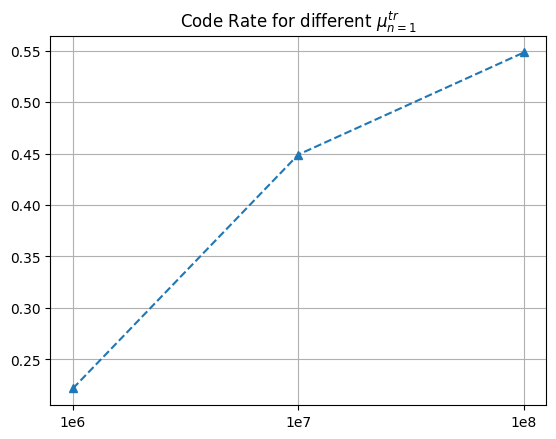

In [39]:
mus_tr_TNKs = []
for mu0_tr in mus_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    Tnk = solve_nk_scipy(system_params, conv_params)
    mus_tr_TNKs.append(Tnk)
    
optimal_ns = np.asarray([Tnk[1] for Tnk in mus_tr_TNKs])
optimal_ks = np.asarray([Tnk[2] for Tnk in mus_tr_TNKs])
r = optimal_ks / optimal_ns

plt.grid()
plt.title(r'$n^*,k^*$ under different $\mu^{tr}_{n=1}$')
plt.plot(optimal_ns, 'o--', label='$n^*$')
plt.plot(optimal_ks, 'x--', label='$k^*$')
plt.xticks(np.arange(len(mus_tr)), labels=xticks)
plt.legend()
plt.show()

plt.grid()
plt.title(r'Code Rate for different $\mu^{tr}_{n=1}$')
plt.plot(r, '^--', label='$r$')
plt.xticks(np.arange(len(mus_tr)), labels=xticks)
plt.show()

# $\theta^{tr}_0$

In [ ]:
# test impact of theta0_tr

mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
# thetas_tr = [1e-9,1e-8,1e-7]
thetas_tr = [1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8]
xticks = '1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8'.split(',')
mus_cmp = [1e7,1e8,1e9]
thetas_cmp = [1e-9,1e-8,1e-7]
# mu0_tr = mu_tr
mu0_tr = 1e8

In [ ]:
thetas_tr_results = []
for theta0_tr in thetas_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_nk(system_params, conv_params)
    print(results)
    thetas_tr_results.append(results)

(100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)


 13%|█▎        | 13/97 [00:08<00:55,  1.51it/s]


((2.070192046242274, 13, 9), (1.954899401360554, 15, 7))
(100000000.0, 2e-09, 1000000000.0, 1e-09, 100000000.0, 2e-09)


 12%|█▏        | 12/97 [00:06<00:47,  1.79it/s]


((2.109373325075632, 13, 9), (2.010144039407351, 14, 7))
(100000000.0, 3e-09, 1000000000.0, 1e-09, 100000000.0, 3e-09)


 12%|█▏        | 12/97 [00:06<00:47,  1.79it/s]


((2.1477200448274587, 13, 9), (2.0624360978417453, 14, 7))
(100000000.0, 4e-09, 1000000000.0, 1e-09, 100000000.0, 4e-09)


 12%|█▏        | 12/97 [00:06<00:47,  1.79it/s]


((2.186508939405572, 13, 9), (2.1122733415153983, 14, 8))
(100000000.0, 5e-09, 1000000000.0, 1e-09, 100000000.0, 5e-09)


 12%|█▏        | 12/97 [00:06<00:47,  1.77it/s]


((2.2218715149911037, 12, 9), (2.1586610210896, 14, 8))
(100000000.0, 6e-09, 1000000000.0, 1e-09, 100000000.0, 6e-09)


 12%|█▏        | 12/97 [00:06<00:48,  1.76it/s]


((2.2569619247172232, 12, 9), (2.205542828855337, 14, 8))
(100000000.0, 7e-09, 1000000000.0, 1e-09, 100000000.0, 7e-09)


 12%|█▏        | 12/97 [00:09<01:07,  1.26it/s]


((2.2935981535878396, 12, 9), (2.2520871397091886, 14, 8))
(100000000.0, 8e-09, 1000000000.0, 1e-09, 100000000.0, 8e-09)


 11%|█▏        | 11/97 [00:07<01:01,  1.40it/s]


((2.329127095355461, 12, 9), (2.2982630230235146, 13, 8))
(100000000.0, 9e-09, 1000000000.0, 1e-09, 100000000.0, 9e-09)


 11%|█▏        | 11/97 [00:07<01:01,  1.39it/s]


((2.3646518421214244, 13, 10), (2.340480607961809, 13, 8))
(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


 11%|█▏        | 11/97 [00:07<01:01,  1.39it/s]

((2.3998791895733698, 13, 10), (2.3833548962065443, 13, 8))


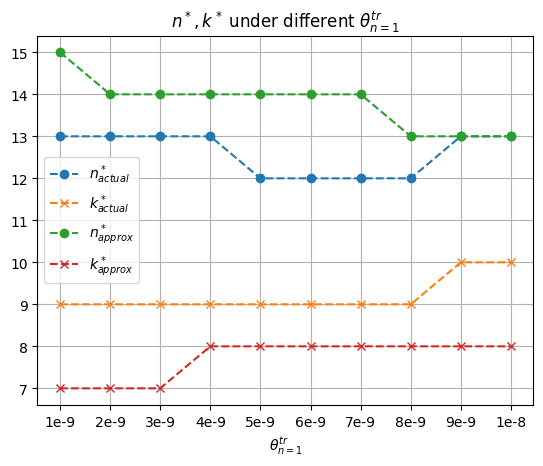

In [ ]:
# draw impact of theta0_tr
optimal_ns_actual = [actual[1] for actual, _ in thetas_tr_results]
optimal_ks_actual = [actual[2] for actual, _ in thetas_tr_results]
optimal_ns_estimated = [estimated[1] for _, estimated in thetas_tr_results]
optimal_ks_estimated = [estimated[2] for _, estimated in thetas_tr_results]
plt.figure()
plt.grid()
plt.title(r'$n^*,k^*$ under different $\theta^{tr}_{n=1}$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.xticks(np.arange(len(thetas_tr)), labels='1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8'.split(','))
plt.xlabel(r'$\theta^{tr}_{n=1}$')
plt.legend()

(100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)
n*,k*=[15.35262779  7.26775408]   T*=2.0395064553126474
(100000000.0, 2e-09, 1000000000.0, 1e-09, 100000000.0, 2e-09)
n*,k*=[15.07505657  7.45272626]   T*=2.0943117917196705
(100000000.0, 3e-09, 1000000000.0, 1e-09, 100000000.0, 3e-09)
n*,k*=[14.84614076  7.61668745]   T*=2.147004499527597
(100000000.0, 4e-09, 1000000000.0, 1e-09, 100000000.0, 4e-09)
n*,k*=[14.65331709  7.76404173]   T*=2.1979432337151783
(100000000.0, 5e-09, 1000000000.0, 1e-09, 100000000.0, 5e-09)
n*,k*=[14.48821642  7.89791902]   T*=2.2473949250154384
(100000000.0, 6e-09, 1000000000.0, 1e-09, 100000000.0, 6e-09)
n*,k*=[14.34496193  8.0206033 ]   T*=2.2955649755979475
(100000000.0, 7e-09, 1000000000.0, 1e-09, 100000000.0, 7e-09)
n*,k*=[14.21922628  8.13381198]   T*=2.3426156464406436
(100000000.0, 8e-09, 1000000000.0, 1e-09, 100000000.0, 8e-09)
n*,k*=[14.10793581  8.23887926]   T*=2.38867787443142
(100000000.0, 9e-09, 1000000000.0, 1e-09, 100000000.0, 9e-0

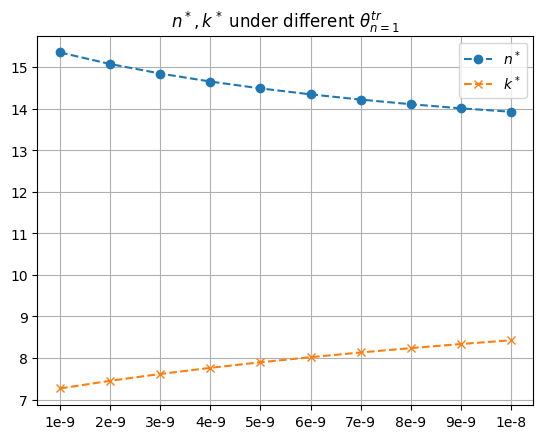

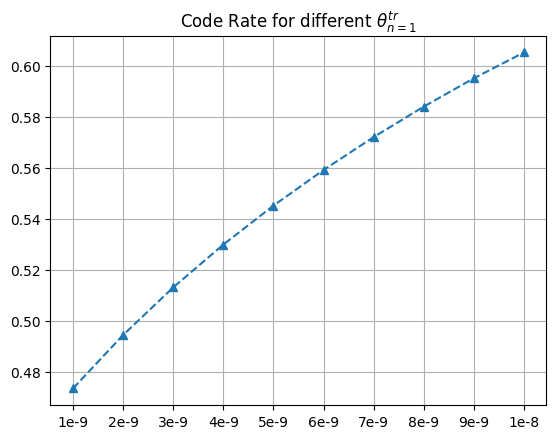

In [ ]:
thetas_tr_TNKs = []
for theta0_tr in thetas_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    Tnk = solve_nk_scipy(system_params, conv_params)
    thetas_tr_TNKs.append(Tnk)
    
optimal_ns = np.asarray([Tnk[1] for Tnk in thetas_tr_TNKs])
optimal_ks = np.asarray([Tnk[2] for Tnk in thetas_tr_TNKs])
r = optimal_ks / optimal_ns

plt.grid()
plt.title(r'$n^*,k^*$ under different $\theta^{tr}_{n=1}$')
plt.plot(optimal_ns, 'o--', label='$n^*$')
plt.plot(optimal_ks, 'x--', label='$k^*$')
plt.xticks(np.arange(len(thetas_tr)), labels=xticks)
plt.legend()
plt.show()

plt.grid()
plt.title(r'Code Rate for different $\theta^{tr}_{n=1}$')
plt.plot(r, '^--', label='$r$')
plt.xticks(np.arange(len(thetas_tr)), labels=xticks)
plt.show()

# $\mu^{cmp}$

In [ ]:
# test impact of mu_cmp

mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
thetas_tr = [1e-9,1e-8,1e-7]
# mus_cmp = [1e7,1e8,1e9]
mus_cmp = [1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9]
xticks = '1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9'.split(',')
thetas_cmp = [1e-9,1e-8,1e-7]

mu0_tr = mu_tr
theta0_tr = theta_tr

In [ ]:
mu_cmp_results = []
for mu_cmp_i in mus_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp_i, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_nk(system_params, conv_params)
    print(results)
    mu_cmp_results.append(results)

(100000000.0, 1e-08, 100000000.0, 1e-09, 100000000.0, 1e-08)


 31%|███       | 30/97 [01:26<03:13,  2.89s/it]


((4.622732021283755, 30, 14), (4.299248553405674, 32, 12))
(100000000.0, 1e-08, 200000000.0, 1e-09, 100000000.0, 1e-08)


 22%|██▏       | 21/97 [00:29<01:45,  1.39s/it]


((3.6701038874450154, 23, 13), (3.466574656958393, 23, 10))
(100000000.0, 1e-08, 300000000.0, 1e-09, 100000000.0, 1e-08)


 19%|█▊        | 18/97 [00:19<01:25,  1.08s/it]


((3.2467276741261264, 19, 12), (3.0985970464654127, 20, 10))
(100000000.0, 1e-08, 400000000.0, 1e-09, 100000000.0, 1e-08)


 16%|█▋        | 16/97 [00:14<01:12,  1.12it/s]


((2.9925503281860024, 17, 11), (2.8840737299756354, 18, 9))
(100000000.0, 1e-08, 500000000.0, 1e-09, 100000000.0, 1e-08)


 15%|█▌        | 15/97 [00:11<01:04,  1.27it/s]


((2.819558713661865, 16, 11), (2.7360115271175967, 17, 9))
(100000000.0, 1e-08, 600000000.0, 1e-09, 100000000.0, 1e-08)


 14%|█▍        | 14/97 [00:09<00:58,  1.42it/s]


((2.6936250178590004, 14, 10), (2.6293116219272474, 16, 9))
(100000000.0, 1e-08, 700000000.0, 1e-09, 100000000.0, 1e-08)


 13%|█▎        | 13/97 [00:08<00:52,  1.59it/s]


((2.59467106033205, 14, 10), (2.5480026479073707, 15, 9))
(100000000.0, 1e-08, 800000000.0, 1e-09, 100000000.0, 1e-08)


 12%|█▏        | 12/97 [00:06<00:46,  1.82it/s]


((2.516804761831465, 13, 10), (2.485222439697564, 14, 8))
(100000000.0, 1e-08, 900000000.0, 1e-09, 100000000.0, 1e-08)


 11%|█▏        | 11/97 [00:05<00:41,  2.09it/s]


((2.4515949449902976, 13, 10), (2.4312560731196324, 13, 8))
(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


 11%|█▏        | 11/97 [00:05<00:41,  2.09it/s]

((2.3995861512078482, 12, 9), (2.3842335931792764, 13, 8))


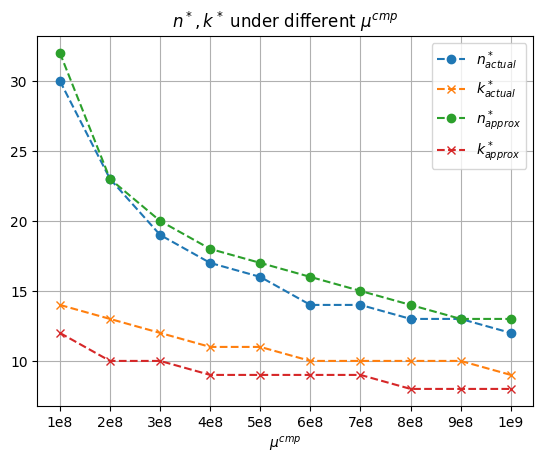

In [ ]:
# draw impact of mu_cmp
optimal_ns_actual = [actual[1] for actual, _ in mu_cmp_results]
optimal_ks_actual = [actual[2] for actual, _ in mu_cmp_results]
optimal_ns_estimated = [estimated[1] for _, estimated in mu_cmp_results]
optimal_ks_estimated = [estimated[2] for _, estimated in mu_cmp_results]
plt.figure()
plt.grid()
plt.title(r'$n^*,k^*$ under different $\mu^{cmp}$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.xticks(np.arange(len(mus_cmp)), labels='1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9'.split(','))
plt.xlabel(r'$\mu^{cmp}$')
plt.legend()

(100000000.0, 1e-08, 100000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[32.11360664 11.86465728]   T*=4.401938538542911
(100000000.0, 1e-08, 200000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[24.14030349 10.62240203]   T*=3.561543594747453
(100000000.0, 1e-08, 300000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[20.66258099  9.98145158]   T*=3.1927896773745754
(100000000.0, 1e-08, 400000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[18.61533581  9.55636813]   T*=2.9756174703706253
(100000000.0, 1e-08, 500000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[17.23801137  9.25436917]   T*=2.829312942132372
(100000000.0, 1e-08, 600000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[16.23319942  9.02062216]   T*=2.7227245910736904
(100000000.0, 1e-08, 700000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[15.461186    8.83215044]   T*=2.640962850777851
(100000000.0, 1e-08, 800000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[14.84583372  8.67575216]   T*=2.5759052036064363
(100000000.0, 1e-08, 900000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[

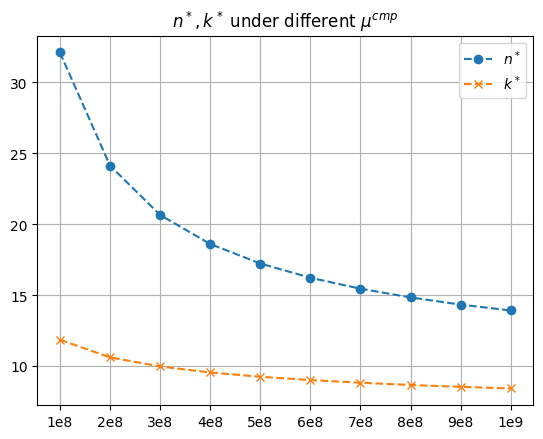

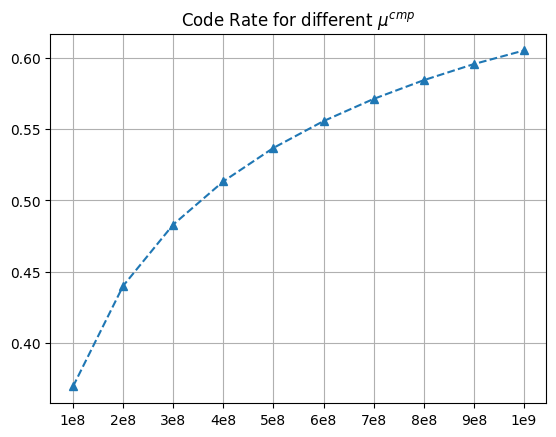

In [ ]:
mus_cmp_TNKs = []
for mu_cmp in mus_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    Tnk = solve_nk_scipy(system_params, conv_params)
    mus_cmp_TNKs.append(Tnk)
    
optimal_ns = np.asarray([Tnk[1] for Tnk in mus_cmp_TNKs])
optimal_ks = np.asarray([Tnk[2] for Tnk in mus_cmp_TNKs])
r = optimal_ks / optimal_ns

plt.grid()
plt.title(r'$n^*,k^*$ under different $\mu^{cmp}$')
plt.plot(optimal_ns, 'o--', label='$n^*$')
plt.plot(optimal_ks, 'x--', label='$k^*$')
plt.xticks(np.arange(len(mus_cmp)), labels=xticks)
plt.legend()
plt.show()

plt.grid()
plt.title(r'Code Rate for different $\mu^{cmp}$')
plt.plot(r, '^--', label='$r$')
plt.xticks(np.arange(len(mus_cmp)), labels=xticks)
plt.show()

# $\theta^{cmp}$

In [ ]:
# test impact of theta_cmp

mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [1e7,1e8,1e9]
# thetas_cmp = [1e-9,1e-8,1e-7]
thetas_cmp = [1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8]
xticks = '1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8'.split(',')

In [ ]:
mu0_tr = mu_tr
theta0_tr = theta_tr
theta_cmp_results = []
for theta_cmp_i in thetas_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp_i, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_nk(system_params, conv_params)
    print(results)
    theta_cmp_results.append(results)

(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


 11%|█▏        | 11/97 [00:05<00:41,  2.06it/s]


((2.399387739111045, 12, 9), (2.3827855782788947, 13, 8))
(100000000.0, 1e-08, 1000000000.0, 2e-09, 100000000.0, 1e-08)


 14%|█▍        | 14/97 [00:09<00:58,  1.41it/s]


((2.7445527083342336, 15, 12), (2.773661827291879, 16, 11))
(100000000.0, 1e-08, 1000000000.0, 3e-09, 100000000.0, 1e-08)


 16%|█▋        | 16/97 [00:15<01:17,  1.05it/s]


((3.0357638140580336, 17, 14), (3.093950961227862, 18, 13))
(100000000.0, 1e-08, 1000000000.0, 4e-09, 100000000.0, 1e-08)


 18%|█▊        | 17/97 [00:24<01:55,  1.45s/it]


((3.2920945926493492, 17, 15), (3.3687827421100485, 19, 14))
(100000000.0, 1e-08, 1000000000.0, 5e-09, 100000000.0, 1e-08)


 20%|█▉        | 19/97 [00:33<02:15,  1.74s/it]


((3.524529823827317, 19, 17), (3.6184104645789312, 21, 16))
(100000000.0, 1e-08, 1000000000.0, 6e-09, 100000000.0, 1e-08)


 21%|██        | 20/97 [00:38<02:26,  1.90s/it]


((3.738847891850768, 20, 18), (3.84538599718016, 22, 17))
(100000000.0, 1e-08, 1000000000.0, 7e-09, 100000000.0, 1e-08)


 22%|██▏       | 21/97 [00:43<02:37,  2.07s/it]


((3.938716289138272, 21, 19), (4.058069584303471, 23, 18))
(100000000.0, 1e-08, 1000000000.0, 8e-09, 100000000.0, 1e-08)


 23%|██▎       | 22/97 [00:45<02:34,  2.06s/it]


((4.128963992963949, 22, 20), (4.257425400076466, 24, 19))
(100000000.0, 1e-08, 1000000000.0, 9e-09, 100000000.0, 1e-08)


 24%|██▎       | 23/97 [00:37<02:01,  1.65s/it]


((4.309014804437654, 23, 21), (4.445093337459504, 25, 20))
(100000000.0, 1e-08, 1000000000.0, 1e-08, 100000000.0, 1e-08)


 25%|██▍       | 24/97 [00:56<02:52,  2.37s/it]

((4.479968939413961, 24, 22), (4.623896667007634, 26, 21))


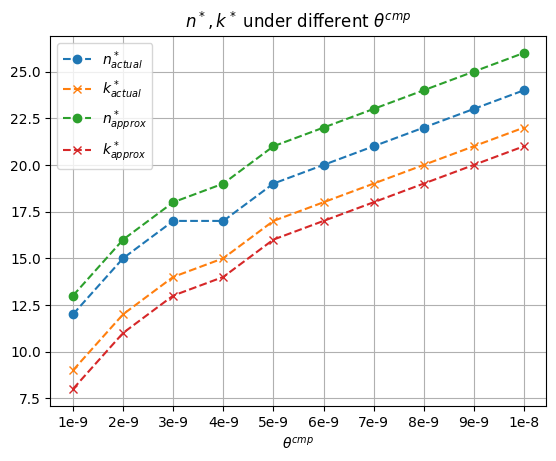

In [ ]:
# draw impact of theta_cmp
optimal_ns_actual = [actual[1] for actual, _ in theta_cmp_results]
optimal_ks_actual = [actual[2] for actual, _ in theta_cmp_results]
optimal_ns_estimated = [estimated[1] for _, estimated in theta_cmp_results]
optimal_ks_estimated = [estimated[2] for _, estimated in theta_cmp_results]
plt.figure()
plt.grid()
plt.title(r'$n^*,k^*$ under different $\theta^{cmp}$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.xticks(np.arange(len(thetas_cmp)), labels='1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8'.split(','))
plt.xlabel(r'$\theta^{cmp}$')
plt.legend()

(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)
n*,k*=[13.92632968  8.42877533]   T*=2.478249654803093
(100000000.0, 1e-08, 1000000000.0, 2e-09, 100000000.0, 1e-08)
n*,k*=[16.40572575 10.801419  ]   T*=2.8626522842953426
(100000000.0, 1e-08, 1000000000.0, 3e-09, 100000000.0, 1e-08)
n*,k*=[18.32581956 12.65843418]   T*=3.1777532120847596
(100000000.0, 1e-08, 1000000000.0, 4e-09, 100000000.0, 1e-08)
n*,k*=[19.93991229 14.2657408 ]   T*=3.45236874230525
(100000000.0, 1e-08, 1000000000.0, 5e-09, 100000000.0, 1e-08)
n*,k*=[21.35414153 15.66943808]   T*=3.6995103637872737
(100000000.0, 1e-08, 1000000000.0, 6e-09, 100000000.0, 1e-08)
n*,k*=[22.62517529 16.9410717 ]   T*=3.9263892225923844
(100000000.0, 1e-08, 1000000000.0, 7e-09, 100000000.0, 1e-08)
n*,k*=[23.79685321 18.10367906]   T*=4.137510031516662
(100000000.0, 1e-08, 1000000000.0, 8e-09, 100000000.0, 1e-08)
n*,k*=[24.88378307 19.18698554]   T*=4.335914617776886
(100000000.0, 1e-08, 1000000000.0, 9e-09, 100000000.0, 1e-08)

C:\Users\SUST\AppData\Local\Temp\ipykernel_10720\661126655.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n * np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))
C:\Users\SUST\AppData\Local\Temp\ipykernel_10720\661126655.py:29: RuntimeWarning: invalid value encountered in log
  return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n * np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))


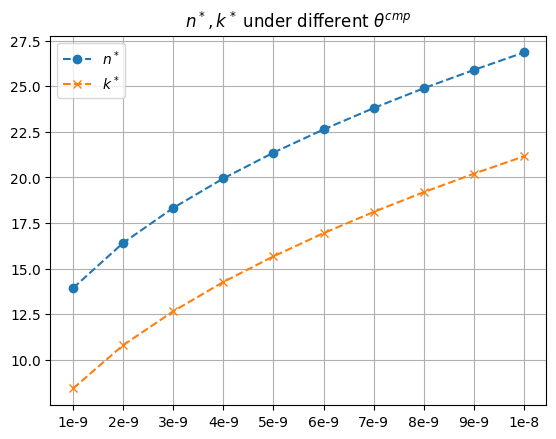

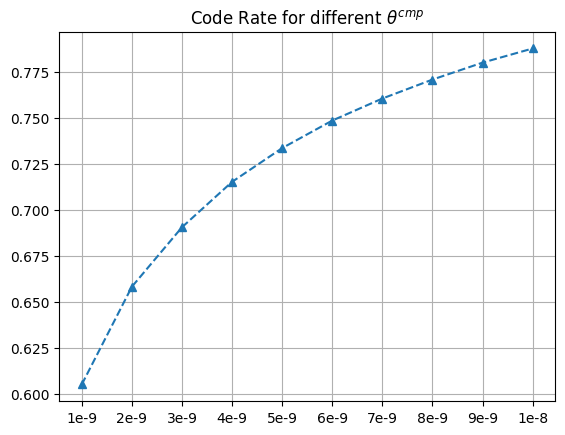

In [ ]:
thetas_cmp_TNKs = []
for theta_cmp in thetas_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    Tnk = solve_nk_scipy(system_params, conv_params)
    thetas_cmp_TNKs.append(Tnk)
    
optimal_ns = np.asarray([Tnk[1] for Tnk in thetas_cmp_TNKs])
optimal_ks = np.asarray([Tnk[2] for Tnk in thetas_cmp_TNKs])
r = optimal_ks / optimal_ns

plt.grid()
plt.title(r'$n^*,k^*$ under different $\theta^{cmp}$')
plt.plot(optimal_ns, 'o--', label='$n^*$')
plt.plot(optimal_ks, 'x--', label='$k^*$')
plt.xticks(np.arange(len(thetas_cmp)), labels=xticks)
plt.legend()
plt.show()

plt.grid()
plt.title(r'Code Rate for different $\theta^{cmp}$')
plt.plot(r, '^--', label='$r$')
plt.xticks(np.arange(len(thetas_cmp)), labels=xticks)
plt.show()